In [ ]:
import numpy as np
from PIL import Image
#from utils import FDA_source_to_target_np
import scipy.misc
import torch
import numpy as np


In [ ]:
def genGaussianKernel(width, height, sigma):
    kernel = np.zeros([width, height])            # creating a blank matrix of kernel size
    for x in range(width):
      for y in range(height):
          kernel[x,y] = 1/(2*np.pi*sigma**2)*np.exp(-((x-width//2)**2+(y-height//2)**2)/(2*sigma**2))     # creating the kernel F = 1/(2*pi*sigma^2) exp(-(x^2+y^2)/(2*sigma^2))
    kernel_2d = kernel/np.sum(kernel)       # Normalizing the kernel
    return kernel_2d

def extract_ampl_phase(fft_im):
    # fft_im: size should be bx3xhxwx2
    fft_amp = fft_im[:,:,:,:,0]**2 + fft_im[:,:,:,:,1]**2
    fft_amp = torch.sqrt(fft_amp)
    fft_pha = torch.atan2( fft_im[:,:,:,:,1], fft_im[:,:,:,:,0] )
    return fft_amp, fft_pha

def low_freq_mutate( amp_src, amp_trg, L=0.01 ):
    _, _, h, w = amp_src.size()
    b = (  np.floor(np.amin((h,w))*L)  ).astype(int)     # get b
    amp_src[:,:,0:b,0:b]     = amp_trg[:,:,0:b,0:b]      # top left
    amp_src[:,:,0:b,w-b:w]   = amp_trg[:,:,0:b,w-b:w]    # top right
    amp_src[:,:,h-b:h,0:b]   = amp_trg[:,:,h-b:h,0:b]    # bottom left
    amp_src[:,:,h-b:h,w-b:w] = amp_trg[:,:,h-b:h,w-b:w]  # bottom right
    return amp_src

def low_freq_mutate_np_gauss( amp_src, amp_trg, L, sigma_gaussian ):
    a_src = np.fft.fftshift( amp_src, axes=(-2, -1) )
    a_trg = np.fft.fftshift( amp_trg, axes=(-2, -1) )

    _, h, w = a_src.shape
    b = (  np.floor(np.amin((h,w))*L)  ).astype(int)
    c_h = np.floor(h/2.0).astype(int)
    c_w = np.floor(w/2.0).astype(int)

    h1 = c_h-b
    h2 = c_h+b+1
    w1 = c_w-b
    w2 = c_w+b+1

    kernel_gauss = genGaussianKernel(h, w, sigma_gaussian)
    print(a_src.shape)
    print(a_trg.shape)
    print(kernel_gauss.shape)
    a_src[:,:,:] = a_trg[:,:,:] * kernel_gauss + a_src[:,:,:] - a_src[:,:,:] * kernel_gauss
    a_src = np.fft.ifftshift( a_src, axes=(-2, -1) )
    return a_src

def FDA_source_to_target(src_img, trg_img, L=0.1):
    # exchange magnitude
    # input: src_img, trg_img

    # get fft of both source and target
    fft_src = torch.rfft( src_img.clone(), signal_ndim=2, onesided=False )
    fft_trg = torch.rfft( trg_img.clone(), signal_ndim=2, onesided=False )

    # extract amplitude and phase of both ffts
    amp_src, pha_src = extract_ampl_phase( fft_src.clone())
    amp_trg, pha_trg = extract_ampl_phase( fft_trg.clone())

    # replace the low frequency amplitude part of source with that from target
    amp_src_ = low_freq_mutate( amp_src.clone(), amp_trg.clone(), L=L )

    # recompose fft of source
    fft_src_ = torch.zeros( fft_src.size(), dtype=torch.float )
    fft_src_[:,:,:,:,0] = torch.cos(pha_src.clone()) * amp_src_.clone()
    fft_src_[:,:,:,:,1] = torch.sin(pha_src.clone()) * amp_src_.clone()

    # get the recomposed image: source content, target style
    _, _, imgH, imgW = src_img.size()
    src_in_trg = torch.irfft( fft_src_, signal_ndim=2, onesided=False, signal_sizes=[imgH,imgW] )

    return src_in_trg

def FDA_source_to_target_np_gauss( src_img, trg_img, L=0.1, sigma_gaussian = 5  ):
    # exchange magnitude
    # input: src_img, trg_img

    src_img_np = src_img #.cpu().numpy()
    trg_img_np = trg_img #.cpu().numpy()

    # get fft of both source and target
    fft_src_np = np.fft.fft2( src_img_np, axes=(-2, -1) )
    fft_trg_np = np.fft.fft2( trg_img_np, axes=(-2, -1) )

    # extract amplitude and phase of both ffts
    amp_src, pha_src = np.abs(fft_src_np), np.angle(fft_src_np)
    amp_trg, pha_trg = np.abs(fft_trg_np), np.angle(fft_trg_np)

    # mutate the amplitude part of source with target
    #_, w, h = src_img.shape
    #kernel_gauss = genGaussianKernel(w, h, sigma_gaussian)
    #ones = np.ones([w,h])
    #print(kernel_gauss.shape)
    #print(src_img.shape)
    #print((amp_src - amp_trg).shape)
    #amp_src_ = amp_src - kernel_gauss * (amp_src - amp_trg)
    amp_src_ = low_freq_mutate_np_gauss( amp_src, amp_trg, L=L, sigma_gaussian = sigma_gaussian )

    # mutated fft of source
    fft_src_ = amp_src_ * np.exp( 1j * pha_src )

    # get the mutated image
    src_in_trg = np.fft.ifft2( fft_src_, axes=(-2, -1) )
    src_in_trg = np.real(src_in_trg)

    return src_in_trg

In [ ]:
# im_src = Image.open("/content/drive/MyDrive/Domain Adaptation/source.jpg").convert('RGB')
# im_trg = Image.open("/content/drive/MyDrive/Domain Adaptation/target1.png").convert('RGB')

# im_src = im_src.resize( (1024,512), Image.BICUBIC )
# im_trg = im_trg.resize( (1024,512), Image.BICUBIC )

# im_src = np.asarray(im_src, np.float32)
# im_trg = np.asarray(im_trg, np.float32)

# im_src = im_src.transpose((2, 0, 1))
# im_trg = im_trg.transpose((2, 0, 1))

# for i in range(1,15):
#   src_in_trg = FDA_source_to_target_np_gauss( im_src, im_trg, L=1, sigma_gaussian = i*0.1)

#   src_in_trg = src_in_trg.transpose((1,2,0))

#   #Image.fromarray(src_in_trg.astype(np.uint8)).save(f'/content/drive/MyDrive/Domain Adaptation/src_in_tar.png', 'png')
#   scipy.misc.toimage(src_in_trg, cmin=0.0, cmax=255.0).save('/content/drive/MyDrive/Domain Adaptation/Medical Results/src_in_tar_{}.png'.format(str(i*0.1)))

In [ ]:
from PIL import Image
import numpy as np

im_src = Image.open("/content/drive/MyDrive/Domain Adaptation/medical DA/source.jpg").convert('RGB')
im_trg = Image.open("/content/drive/MyDrive/Domain Adaptation/medical DA/target.png").convert('RGB')

im_src = im_src.resize( (1024,512), Image.BICUBIC )
im_trg = im_trg.resize( (1024,512), Image.BICUBIC )

im_src = np.asarray(im_src, np.float32)
im_trg = np.asarray(im_trg, np.float32)

im_src = im_src.transpose((2, 0, 1))
im_trg = im_trg.transpose((2, 0, 1))

for i in range(1,10):
  src_in_trg = FDA_source_to_target_np_gauss( im_src, im_trg, L=1, sigma_gaussian = i*0.1)

  src_in_trg = src_in_trg.transpose((1,2,0))

  #Image.fromarray(src_in_trg.astype(np.uint8)).save(f'/content/drive/MyDrive/Domain Adaptation/src_in_tar.png', 'png')
  Image.fromarray(np.uint8(src_in_trg)).save('/content/drive/MyDrive/Domain Adaptation/medical DA/results/s_t{}.png'.format(str(i*0.1)))


<ipython-input-4-ca266b514309>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(100,100))


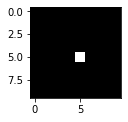

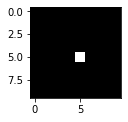

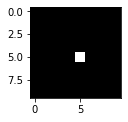

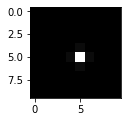

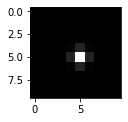

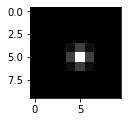

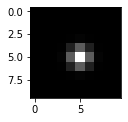

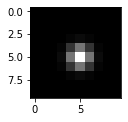

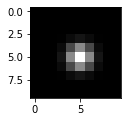

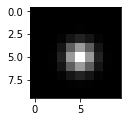

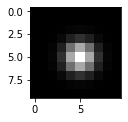

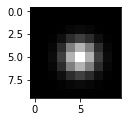

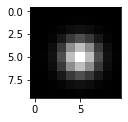

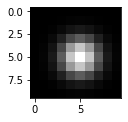

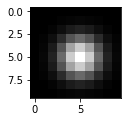

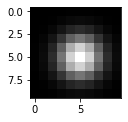

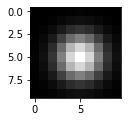

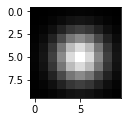

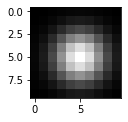

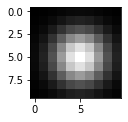

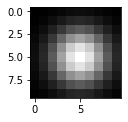

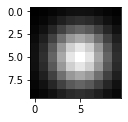

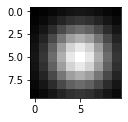

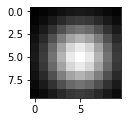

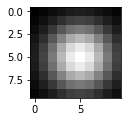

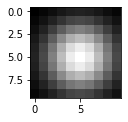

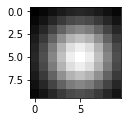

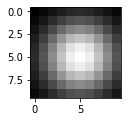

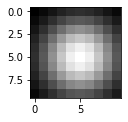

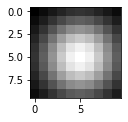

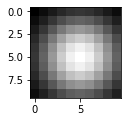

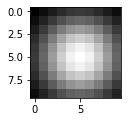

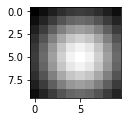

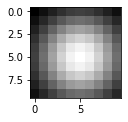

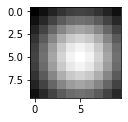

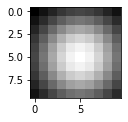

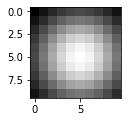

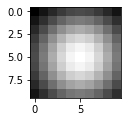

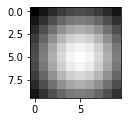

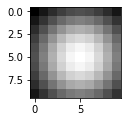

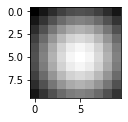

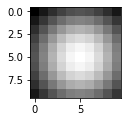

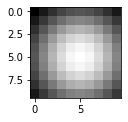

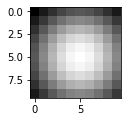

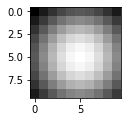

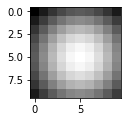

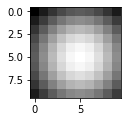

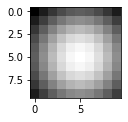

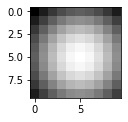

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
for i in range(1,50):
  fig = plt.figure(figsize=(100,100))
  plt.subplot( 50,1, i)
  gaussian = genGaussianKernel(10, 10, i*0.1)
  # plt.imshow(gaussian, interpolation='none', cmap=cm.jet)
  plt.imshow(gaussian, interpolation='none', cmap='gray')
  #plt.title('Sigma =', i*0.1)

**Without Gaussian**

In [ ]:
import torch
import numpy as np

def extract_ampl_phase(fft_im):
    # fft_im: size should be bx3xhxwx2
    fft_amp = fft_im[:,:,:,:,0]**2 + fft_im[:,:,:,:,1]**2
    fft_amp = torch.sqrt(fft_amp)
    fft_pha = torch.atan2( fft_im[:,:,:,:,1], fft_im[:,:,:,:,0] )
    return fft_amp, fft_pha

def low_freq_mutate( amp_src, amp_trg, L=0.1 ):
    _, _, h, w = amp_src.size()
    b = (  np.floor(np.amin((h,w))*L)  ).astype(int)     # get b
    amp_src[:,:,0:b,0:b]     = amp_trg[:,:,0:b,0:b]      # top left
    amp_src[:,:,0:b,w-b:w]   = amp_trg[:,:,0:b,w-b:w]    # top right
    amp_src[:,:,h-b:h,0:b]   = amp_trg[:,:,h-b:h,0:b]    # bottom left
    amp_src[:,:,h-b:h,w-b:w] = amp_trg[:,:,h-b:h,w-b:w]  # bottom right
    return amp_src

def low_freq_mutate_np( amp_src, amp_trg, L=0.1 ):
    a_src = np.fft.fftshift( amp_src, axes=(-2, -1) )
    a_trg = np.fft.fftshift( amp_trg, axes=(-2, -1) )

    _, h, w = a_src.shape
    b = (  np.floor(np.amin((h,w))*L)  ).astype(int)
    c_h = np.floor(h/2.0).astype(int)
    c_w = np.floor(w/2.0).astype(int)

    h1 = c_h-b
    h2 = c_h+b+1
    w1 = c_w-b
    w2 = c_w+b+1

    a_src[:,h1:h2,w1:w2] = a_trg[:,h1:h2,w1:w2]
    a_src = np.fft.ifftshift( a_src, axes=(-2, -1) )
    return a_src

def FDA_source_to_target(src_img, trg_img, L=0.1):
    # exchange magnitude
    # input: src_img, trg_img

    # get fft of both source and target
    fft_src = torch.rfft( src_img.clone(), signal_ndim=2, onesided=False )
    fft_trg = torch.rfft( trg_img.clone(), signal_ndim=2, onesided=False )

    # extract amplitude and phase of both ffts
    amp_src, pha_src = extract_ampl_phase( fft_src.clone())
    amp_trg, pha_trg = extract_ampl_phase( fft_trg.clone())

    # replace the low frequency amplitude part of source with that from target
    amp_src_ = low_freq_mutate( amp_src.clone(), amp_trg.clone(), L=L )

    # recompose fft of source
    fft_src_ = torch.zeros( fft_src.size(), dtype=torch.float )
    fft_src_[:,:,:,:,0] = torch.cos(pha_src.clone()) * amp_src_.clone()
    fft_src_[:,:,:,:,1] = torch.sin(pha_src.clone()) * amp_src_.clone()

    # get the recomposed image: source content, target style
    _, _, imgH, imgW = src_img.size()
    src_in_trg = torch.irfft( fft_src_, signal_ndim=2, onesided=False, signal_sizes=[imgH,imgW] )

    return src_in_trg

def FDA_source_to_target_np( src_img, trg_img, L=0.1 ):
    # exchange magnitude
    # input: src_img, trg_img

    src_img_np = src_img #.cpu().numpy()
    trg_img_np = trg_img #.cpu().numpy()

    # get fft of both source and target
    fft_src_np = np.fft.fft2( src_img_np, axes=(-2, -1) )
    fft_trg_np = np.fft.fft2( trg_img_np, axes=(-2, -1) )

    # extract amplitude and phase of both ffts
    amp_src, pha_src = np.abs(fft_src_np), np.angle(fft_src_np)
    amp_trg, pha_trg = np.abs(fft_trg_np), np.angle(fft_trg_np)

    # mutate the amplitude part of source with target
    amp_src_ = low_freq_mutate_np( amp_src, amp_trg, L=L )

    # mutated fft of source
    fft_src_ = amp_src_ * np.exp( 1j * pha_src )

    # get the mutated image
    src_in_trg = np.fft.ifft2( fft_src_, axes=(-2, -1) )
    src_in_trg = np.real(src_in_trg)

    return src_in_trg

im_src = Image.open("/content/drive/MyDrive/Domain Adaptation/medical DA/source.jpg").convert('RGB')
im_trg = Image.open("/content/drive/MyDrive/Domain Adaptation/medical DA/target.png").convert('RGB')

im_src = im_src.resize( (1024,512), Image.BICUBIC )
im_trg = im_trg.resize( (1024,512), Image.BICUBIC )

im_src = np.asarray(im_src, np.float32)
im_trg = np.asarray(im_trg, np.float32)

im_src = im_src.transpose((2, 0, 1))
im_trg = im_trg.transpose((2, 0, 1))

src_in_trg = FDA_source_to_target_np( im_src, im_trg, L=0.01)

src_in_trg = src_in_trg.transpose((1,2,0))

#Image.fromarray(src_in_trg.astype(np.uint8)).save(f'/content/drive/MyDrive/Domain Adaptation/src_in_tar.png', 'png')
Image.fromarray(np.uint8(src_in_trg)).save('/content/drive/MyDrive/Domain Adaptation/Medical Results/src_in_tar_noGauss.png')

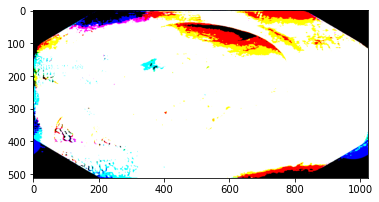

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(src_in_trg)
plt.show()

**TESTING**

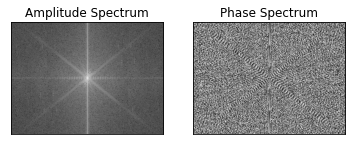

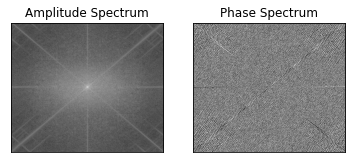

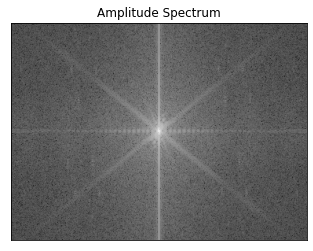

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('/content/drive/MyDrive/Domain Adaptation/medical DA/target.png', 0)
img1 = cv2.imread('/content/drive/MyDrive/Domain Adaptation/medical DA/source.jpg', 0)
# img = cv2.resize(img, (1024, 1024))
# img1 = cv2.resize(img1, (1024, 1024))


f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))
amp, pha = np.abs(fshift), np.angle(fshift)


f1 = np.fft.fft2(img1)
fshift1 = np.fft.fftshift(f1)
magnitude_spectrum1 = 20*np.log(np.abs(fshift1))
amp1, pha1 = np.abs(fshift1), np.angle(fshift1)

# amp_1 = low_freq_mutate_np_gauss( amp, amp1, L= 1 , sigma_gaussian = 0.5 )
w, h = img.shape
kernel_gauss = genGaussianKernel(w, h, 1)
ones = np.ones([w,h])
# print(kernel_gauss.shape)
# print(img.shape)
# print((amp_src - amp_trg).shape)
# amp_src_ = magnitude_spectrum1 - kernel_gauss * (magnitude_spectrum1 - magnitude_spectrum)


# plt.subplot(121),plt.imshow(img, cmap = 'gray')
# plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(121),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Amplitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(pha, cmap = 'gray')
plt.title('Phase Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

plt.subplot(121),plt.imshow(magnitude_spectrum1, cmap = 'gray')
plt.title('Amplitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(pha1, cmap = 'gray')
plt.title('Phase Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

plt.subplot(111),plt.imshow(magnitude_spectrum*0.2, cmap = 'gray')
plt.title('Amplitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

